In [1]:
using PyPlot
using LinearAlgebra
using Statistics
using Random

Random.seed!(1234567);

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/cdesa/.julia/packages/PyPlot/4wzW1/src/init.jl:192


### GD vs SGD example: linear regression

Loss function is 
$$f_i(w) = \frac{1}{2} (w^T x_i - y_i)^2.$$
We'll sample a random dataset over $d$ dimensions in which
$$x_i \sim \mathcal{N}(0, I)$$
and for some constant unit vector $u$,
$$y_i = u^T x_i + \mathcal{N}(0,0.1^2).$$

In [2]:
struct LinRegDataset
    Xs :: Array{Array{Float64,1},1}
    Ys :: Array{Float64,1}
end

function generate_synthetic_dataset(d::Int64, n::Int64)
    Random.seed!(8675309);
    
    # generate random unit vector
    u = randn(d); u /= norm(u);
    
    Xs = [randn(d) for i = 1:n];
    Ys = [dot(u, Xs[i]) + 0.1 * randn() for i = 1:n];
    
    return LinRegDataset(Xs, Ys);
end

d = 100;
n = 1000;
    
TD = generate_synthetic_dataset(d, n);

In [3]:
function total_loss(TD :: LinRegDataset, w :: Array{Float64,1})
    return mean([(dot(w, TD.Xs[i]) - TD.Ys[i])^2 / 2 for i = 1:n]);
end

total_loss (generic function with 1 method)

In [4]:
total_loss(TD, zeros(d))

0.48214926002770636

In [5]:
function grad_fi(TD :: LinRegDataset, i::Int64, w :: Array{Float64,1})
    return TD.Xs[i] * (dot(w, TD.Xs[i]) - TD.Ys[i]);
end

function total_grad(TD :: LinRegDataset, w :: Array{Float64,1})
    n = length(TD.Xs);
    return mean([grad_fi(TD, i, w) for i = 1:n]);
end

total_grad (generic function with 1 method)

In [6]:
function gradient_descent(TD :: LinRegDataset, alpha :: Float64, num_iters :: Int64, loss_interval :: Int64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # vector to store loss after t iterations
    measurement_times = Float64[0];
    loss_at_t = Float64[total_loss(TD, w)];
    # run iteratively
    for t = 1:num_iters
        w = w - alpha * total_grad(TD, w);
        if t % loss_interval == 0
            push!(measurement_times, t);
            push!(loss_at_t, total_loss(TD, w));
        end
    end
    return (measurement_times, loss_at_t)
end

function stochastic_gradient_descent(TD :: LinRegDataset, alpha :: Float64, num_iters :: Int64, loss_interval :: Int64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # vector to store loss after t iterations
    measurement_times = Float64[0];
    loss_at_t = Float64[total_loss(TD, w)];
    # run iteratively
    for t = 1:num_iters
        i = rand(1:n);
        w = w - alpha * grad_fi(TD, i, w);
        if t % loss_interval == 0
            push!(measurement_times, t);
            push!(loss_at_t, total_loss(TD, w));
        end
    end
    return (measurement_times, loss_at_t)
end

stochastic_gradient_descent (generic function with 1 method)

In [7]:
alpha = 0.01;
num_iters = 10000;
(gd_t, gd_loss) = gradient_descent(TD, alpha, num_iters, 10);
(sgd_t, sgd_loss) = stochastic_gradient_descent(TD, alpha, num_iters, 10);

# also, benchmark the time it takes to run
@time gradient_descent(TD, alpha, num_iters, num_iters);
@time stochastic_gradient_descent(TD, alpha, num_iters, num_iters);
 

  4.988261 seconds (20.05 M allocations: 16.782 GiB, 42.66% gc time)
  0.004151 seconds (30.02 k allocations: 25.652 MiB)


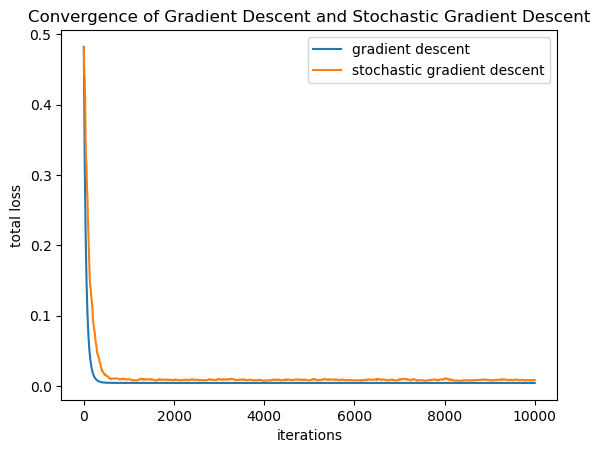

In [8]:
plot(gd_t, gd_loss; label="gradient descent");
plot(sgd_t, sgd_loss; label="stochastic gradient descent");
legend();
title("Convergence of Gradient Descent and Stochastic Gradient Descent");
xlabel("iterations");
ylabel("total loss");

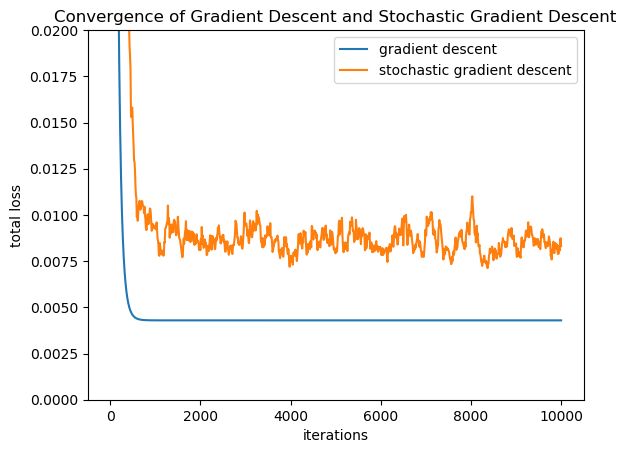

In [9]:
plot(gd_t, gd_loss; label="gradient descent");
plot(sgd_t, sgd_loss; label="stochastic gradient descent");
legend();
title("Convergence of Gradient Descent and Stochastic Gradient Descent");
xlabel("iterations");
ylabel("total loss");
ylim([0.0,0.02]);

Notice that SGD with a constant step size _did not_ converge asymptotically to as low of a loss that gradient descent did. Instead, it converged down to some level, and then the loss stopped decreasing and the value of the loss is noisy. This is sometimes called _converging to a noise ball_.

Often, converging to a noise ball is fine: we don't always need the exact solution to the optimization problem.

**Question: Why might it be fine to get an approximate solution to an optimization problem for training?**

.

.

.

.

Still, it is good to be able to solve optimization problems to arbitrary accuracy if we want to. We can do this with stochastic gradient descent by decreasing the step size.
Even using a smaller constant step size will work.

In [8]:
alpha2 = 0.001;
(sgd_t2, sgd_loss2) = stochastic_gradient_descent(TD, alpha2, num_iters, 10);
alpha3 = 0.0001;
(sgd_t3, sgd_loss3) = stochastic_gradient_descent(TD, alpha3, num_iters, 10);

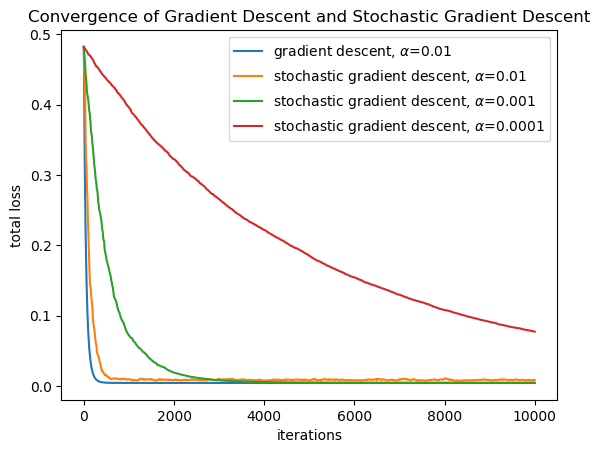

In [10]:
plot(gd_t, gd_loss; label="gradient descent, \$\\alpha\$=$alpha");
plot(sgd_t, sgd_loss; label="stochastic gradient descent, \$\\alpha\$=$alpha");
plot(sgd_t2, sgd_loss2; label="stochastic gradient descent, \$\\alpha\$=$alpha2");
plot(sgd_t3, sgd_loss3; label="stochastic gradient descent, \$\\alpha\$=$alpha3");
legend();
title("Convergence of Gradient Descent and Stochastic Gradient Descent");
xlabel("iterations");
ylabel("total loss");

#ylim([0.0,0.02]);

**Question: What trade-off is illustrated in this figure?**

Another alternative: rather than making the step size smaller, make the gradient estimates more accurate by using a sample size larger than $1$ (remember Hoeffding's inequality: as the sample size gets larger the error of the estimates becomes smaller). This is called **minibatch SGD**.

In [12]:
function minibatch_stochastic_gradient_descent(TD :: LinRegDataset, alpha :: Float64, batch_size :: Int64, num_iters :: Int64, loss_interval :: Int64)
    n = length(TD.Xs);
    d = length(TD.Xs[1]);
    # initialize the parameters to zero
    w = zeros(d);
    # vector to store loss after t iterations
    measurement_times = Float64[0];
    loss_at_t = Float64[total_loss(TD, w)];
    # run iteratively
    for t = 1:num_iters
        is = rand(1:n, batch_size);
        w = w - alpha * mean([grad_fi(TD, i, w) for i in is]);
        if t % loss_interval == 0
            push!(measurement_times, t);
            push!(loss_at_t, total_loss(TD, w));
        end
    end
    return (measurement_times, loss_at_t)
end

minibatch_stochastic_gradient_descent (generic function with 1 method)

In [13]:
batch_size = 5;

(sgd_t3, sgd_loss3) = minibatch_stochastic_gradient_descent(TD, alpha, batch_size, num_iters, 10);

# also, benchmark the time it takes to run, compared with plain SGD
@time stochastic_gradient_descent(TD, alpha, num_iters, num_iters);
@time minibatch_stochastic_gradient_descent(TD, alpha, batch_size, num_iters, num_iters);

  0.005356 seconds (30.02 k allocations: 25.652 MiB, 33.50% gc time)
  0.016987 seconds (160.02 k allocations: 105.608 MiB, 16.27% gc time)


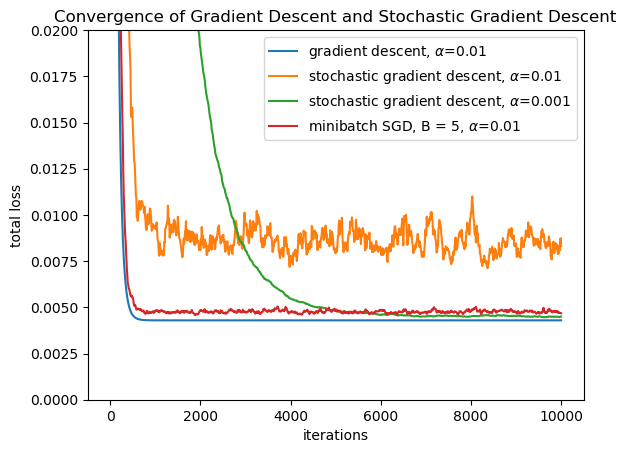

In [14]:
plot(gd_t, gd_loss; label="gradient descent, \$\\alpha\$=$alpha");
plot(sgd_t, sgd_loss; label="stochastic gradient descent, \$\\alpha\$=$alpha");
plot(sgd_t2, sgd_loss2; label="stochastic gradient descent, \$\\alpha\$=$alpha2");
plot(sgd_t3, sgd_loss3; label="minibatch SGD, B = $batch_size, \$\\alpha\$=$alpha");
legend();
title("Convergence of Gradient Descent and Stochastic Gradient Descent");
xlabel("iterations");
ylabel("total loss");

ylim([0.0,0.02]);

**Question: What trade-off is illustrated in this figure?**